In [1]:
import MeCab

import re
import os
import gc

import numpy as np
import pandas as pd
from tqdm import tqdm

import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
# sns.set(font='IPAexGothic')

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pwd

/Users/kenta_kasugai/competition/nishika_akutagawa/notebook


In [3]:
train = pd.read_csv(f'../input/train.csv')
test = pd.read_csv(f'../input/test.csv')

In [4]:
train.head()

,writing_id,body,author
0,0,\r\n 先ごろの本欄に僕の「風報」にかいた「天皇陛下に捧ぐる言葉」を評して俗うけを狙った媚...,0
1,1,\r\n 旅の眼に映じた外国の正月をといふお需めで、一昔前の記憶から探してみたが、其処にはほ...,0
2,2,\r\n 或る心持のよい夕方、日比谷公園の樹の繁みの間で、若葉楓の梢を眺めていたら、どこから...,0
3,3,\r\n\r\n［＃３字下げ］一［＃「一」は中見出し］\r\n\r\n 島々《しま／＼》と云...,1
4,7,\r\n\r\n 或る田舎に母と子とが住んでいた。そして或る年の秋、次のようなことがあった。...,0


In [5]:
test.head()

,writing_id,body
0,4,\r\n\r\n 一\r\n\r\n 夕方降り出した雨はその晩遅くまで続いた。しとし...
1,5,\r\n\r\n この「東北文学」という雑誌の貴重な紙面の端をわずか拝借して申し上げます。ど...
2,6,\r\n\r\n 幼少のころ、高知《こうち》の城下から東に五六里離れた親類の何かの饗宴《きょ...
3,10,\r\n\r\n ○\r\n「三人姉妹」で、マーシャがどんな風に活か...
4,11,\r\n\r\n［＃５字下げ］眼鏡［＃「眼鏡」は中見出し］\r\n\r\n 或日、趣味に関し...


In [6]:
data = pd.concat([train, test])

In [7]:
data = data.reset_index(drop=True)

In [8]:
len(data)

4732

In [9]:
del train, test
gc.collect()

159

# 特徴量エンジニアリング

## 漢字・ひらがな…

In [8]:
#http://tamomo.com/Aozora/jisyo/kyuuji_tabei006.txt

old_kanji = pd.read_table("../input/old_kanji.tsv", usecols=["kanji"])

In [9]:
old_kanji = old_kanji.drop(index=[1808, 1809, 1810])["kanji"].values

In [10]:
old_kana = np.array(["ヰ", "ヱ", "ゐ", "ゑ"])

In [11]:
komoji = np.array(["ぁ", "ぃ", "ぅ", "ぇ", "ぉ", "っ", "ゃ", "ゅ", "ょ", "ゎ"])

In [12]:
hagyo = np.array(["は", "ひ", "ふ", "へ", "ほ"])

In [15]:
def hyoki(bodies):
    df = pd.DataFrame(columns=["letter_number", "kanji", "hiragana", "katakana", "digit",
                               "alphabet", "old_kanji", "old_hiragana", "old", "lowercase",
                               "hagyo", "kakko", "kagikakko", "kutoten"])
    for i, body in tqdm(enumerate(bodies)):
        body = body.replace("\u3000", "").strip().replace("\r\n", "").strip()
        df.loc[i, "kanji"] = len(re.findall("[\u4E00-\u9FD0]", repr(body)))/len(body)
        df.loc[i, "hiragana"] = len(re.findall('[ぁ-ゟ]', repr(body)))/len(body)
        df.loc[i, "katakana"] = (len(re.findall('[\ァ-ヿ]', repr(body)))+len(re.findall('[ｦ-ﾟ]', repr(body))))/len(body)
        df.loc[i, "digit"] = len(re.findall('\d', repr(body)))/len(body)
        df.loc[i, "alphabet"] = len(re.findall('[a-zA-Zａ-ｚＡ-Ｚ]', repr(body)))/len(body)
        df.loc[i, "old_kanji"] = sum([len(re.findall(s, repr(body))) for s in old_kanji])/len(body)
        df.loc[i, "old_hiragana"] = sum([len(re.findall(s, repr(body))) for s in old_kana])/len(body)
        df.loc[i, "old"] = df.loc[i, "old_kanji"]+df.loc[i, "old_hiragana"]
        df.loc[i, "lowercase"] = sum([len(re.findall(s, repr(body))) for s in komoji])/len(body)
        df.loc[i, "hagyo"] = sum([len(re.findall(s, repr(body))) for s in hagyo])/len(body)
        df.loc[i, "kakko"] = len(re.findall('[（-）]', repr(body)))/len(body)
        df.loc[i, "kagikakko"] = len(re.findall('[「-」]', repr(body)))/len(body)
        df.loc[i, "kutoten"] = len(re.findall('[、-。]', repr(body)))/len(body)
        df.loc[i, "letter_number"] = len(body)
    df = df.astype(float)
    return df

In [16]:
hyoki_df = hyoki(data["body"])

4732it [13:06,  5.53it/s]


In [17]:
hyoki_df.to_csv("../input/feature_hyoki.csv")

In [10]:
from sklearn.manifold import TSNE

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0, n_jobs=-1)

In [12]:
from scipy.stats import zscore

In [13]:
from sklearn.decomposition import PCA

In [76]:
tmp = pd.concat([data["author"], hyoki_df], axis=1).dropna()
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(zscore, axis=0)

In [77]:
tmp

,author,letter_number,kanji,hiragana,katakana,digit,alphabet,old_kanji,old_hiragana,old,lowercase,hagyo,kakko,kagikakko,kutoten
0,0.0,-0.425115,0.188191,0.235625,0.360564,-0.279048,-0.138367,-0.261499,-0.586492,-0.398882,-0.439578,-1.448692,-0.370388,0.105635,-0.095506
1,0.0,-0.387190,0.484649,-0.268144,0.024364,-0.279048,-0.138367,-0.386971,0.845293,-0.128233,-1.131747,0.746022,-0.370388,-0.070721,1.129052
2,0.0,-0.434117,0.732492,-0.374683,0.842989,-0.279048,-0.138367,-0.386971,-0.586492,-0.514378,0.924943,-1.258838,-0.370388,-0.605917,-0.743559
3,1.0,-0.230697,0.661649,-0.848599,-0.690462,0.860616,-0.098912,-0.329997,1.552553,0.114956,-1.131747,0.474164,-0.370388,0.128927,0.370399
4,0.0,-0.232188,0.684869,-0.013869,-0.787422,-0.279048,-0.098653,-0.348739,-0.586492,-0.479186,1.188226,-0.427501,-0.211921,-0.068469,0.225894
5,0.0,0.437464,0.039495,-0.348395,-0.093844,-0.117388,-0.027553,-0.328782,-0.586492,-0.460816,0.960095,-0.468569,-0.089005,1.532780,-0.078433
6,0.0,-0.314803,-0.146138,1.383426,-0.541498,-0.279048,-0.138367,-0.386971,-0.586492,-0.514378,0.656093,-0.780486,-0.370388,-0.904426,-0.852789
7,1.0,-0.336269,-0.180311,-0.199492,1.379957,-0.279048,0.447042,-0.105186,1.457239,0.296187,-1.131747,2.094067,-0.078396,-0.893263,0.131016
8,0.0,0.156382,0.158558,-0.430935,-0.296840,0.003437,-0.138367,3.623709,0.064209,3.352915,-1.131747,0.738208,-0.370388,1.812357,-0.391254
9,0.0,0.061730,-0.061942,0.038743,1.487330,-0.279048,-0.103703,-0.370286,-0.586492,-0.499019,0.626296,-0.164507,-0.232072,-0.361509,-0.285101


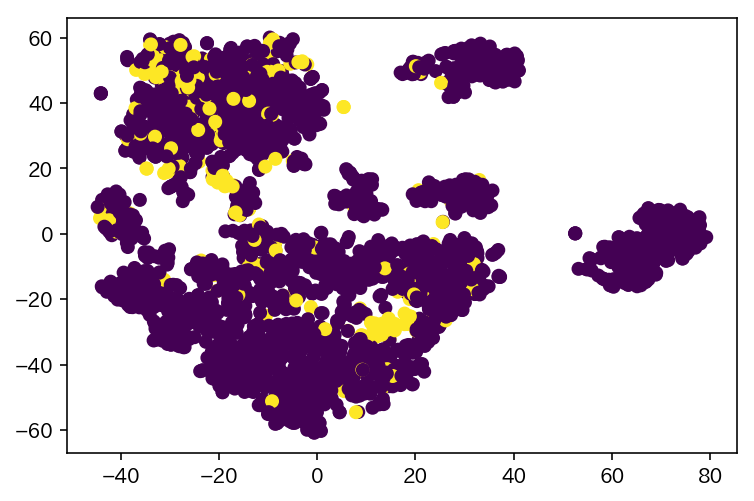

In [81]:
reduced = TSNE(n_components=2, random_state=0).fit_transform(tmp.drop("author", axis=1))
plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])

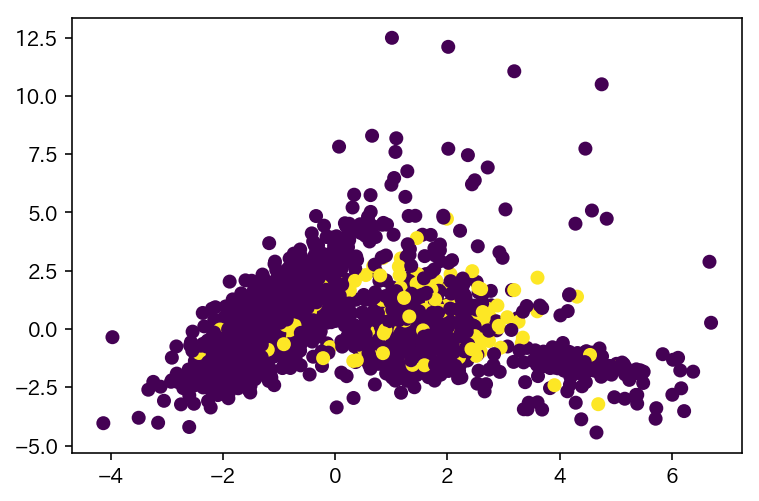

In [88]:
reduced = PCA(n_components=2).fit_transform(tmp.drop("author", axis=1))
plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])

In [83]:
kmeans.fit(tmp.drop("author", axis=1))
kmeans_df = pd.DataFrame(data=[tmp["author"], kmeans.labels_]).T

In [84]:
hoge = kmeans_df.groupby("Unnamed 0").sum()/kmeans_df.groupby("Unnamed 0").count()
piyo = (kmeans_df.groupby("Unnamed 0").count() - kmeans_df.groupby("Unnamed 0").sum())/kmeans_df.groupby("Unnamed 0").count()

In [85]:
pd.concat([kmeans_df.groupby("Unnamed 0").count(), hoge, piyo], axis=1)

,author,author,author
Unnamed 0,,,
0.0,795,0.152201,0.847799
1.0,559,0.069767,0.930233
2.0,224,0.058036,0.941964
3.0,211,0.023697,0.976303
4.0,607,0.062603,0.937397
5.0,85,0.176471,0.823529
6.0,320,0.006250,0.993750
7.0,475,0.040000,0.960000
8.0,6,0.000000,1.000000


In [ ]:
del hyoki_df
gc.collect()

## 単語

https://techacademy.jp/magazine/18915
エスケープシーケンス	意味  
\a	ベル  
\b	 バックスペース  
\f	改ページ  
\n	改行  
\r	キャリッジリターン  
\t	水平タブ  
\v	垂直タブ  
\\	「\」そのもの  
\”	「”」ダブルクォーテーション  
\’	「’」シングルクォーテーション  
\nnn	8進数nnnでASCIIコードの文字を指定  
\xhh	16進数nnでASCIIコードの文字を指定  
\uhhhh	16進数hhhhでUnicodeの文字を指定  
\0	NULL  

\r: 復帰。キャレットを左端の位置に戻すこと  
\n: 改行。キャレットを新しい行に移動すること  
\u3000: 全角スペース

In [10]:
mecab = MeCab.Tagger("-Ochasen")

In [11]:
def word(bodies):
    word_list = []
    for body in tqdm(bodies):
        node = mecab.parseToNode(body)
        words = []
        while node:
            words.append(node.feature.split(',')[6])
            node = node.next
        word_list.append(words)
    return word_list

In [12]:
word_list = word(data["body"])

100%|██████████| 4732/4732 [00:43<00:00, 136.03it/s]


In [17]:
from itertools import chain

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
def pre_bow(word_list):
    word_list_bow = []
    for word in word_list:
        word_list_bow.append(" ".join(word))
    return word_list_bow

In [56]:
docs = np.array(pre_bow(word_list))
count = CountVectorizer()
bags = count.fit_transform(docs)
features = count.get_feature_names()

In [78]:
word_df = pd.DataFrame(data=bags.toarray(), columns=features)

In [79]:
word_df

,γ線,〆切,あぁ,ああ,ああなる,あい,あいあい,あいかわらず,あいかわる,あいがん,...,ｓ子,ｓｆ,ｓｏｓ,ｔｋ,ｔｋｏ,ｕｓａ,ｗｃ,ｘ線,ｙｗｃａ,ｚ旗
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
word_df.to_csv("../input/feature_word.csv")

In [ ]:
del word_df
gc.collect()

## 品詞

In [18]:
adjective0_list = []
adjective01_list = []
adjective012_list = []
katsuyo0_list = []
katsuyo01_list = []
for body in tqdm(data["body"]):
    node = mecab.parseToNode(body)
    adjective0 = []
    adjective01 = []
    adjective012 = []
    katsuyo0 = []
    katsuyo01 = []
    while node:
        adjective0.append(node.feature.split(',')[0])
        adjective01.append(node.feature.split(',')[0]+node.feature.split(',')[1])
        adjective012.append(node.feature.split(',')[0]+node.feature.split(',')[1]+node.feature.split(',')[2])
        katsuyo0.append(node.feature.split(',')[4])
        katsuyo01.append(node.feature.split(',')[4]+node.feature.split(',')[5])
        node = node.next
    adjective0_list.append(adjective0)
    adjective01_list.append(adjective01)
    adjective012_list.append(adjective012)
    katsuyo0_list.append(katsuyo0)
    katsuyo01_list.append(katsuyo01)

100%|██████████| 4732/4732 [03:56<00:00, 25.06it/s]


In [89]:
# def hinshi(hinshi_list):
#     columns = pd.Series(list(chain.from_iterable(hinshi_list))).value_counts().index
#     df = pd.DataFrame(index=range(len(data)), columns=columns)
#     for i, hinshi in tqdm(enumerate(hinshi_list)):
#         tmp = pd.Series(hinshi).value_counts()
#         for j in range(len(tmp)):
#             col = tmp.index[j]
#             val = tmp.values[j]/len(hinshi)
#             try:
#                 df.loc[i, col] = val
#             except:
#                 pass
#     df = df.replace(np.nan, 0.0)
#     return df

In [60]:
# def hinshi(hinshi_list):
#     df = pd.DataFrame()
#     for hinshi in tqdm(hinshi_list):
#         tmp = pd.Series(hinshi).value_counts()
#         df = pd.concat([df, tmp], axis=1)
#     df = df.replace(np.nan, 0.0).T
#     df.index = range(len(hinshi_list))
#     return df

In [70]:
def hinshi(hinshi_list):
    df = pd.DataFrame()
    for hinshi in tqdm(hinshi_list):
        tmp = pd.DataFrame(pd.Series(hinshi).value_counts()).T
        df = pd.concat([df, tmp])
    df = df.replace(np.nan, 0)
    df = df.astype(int)
    df.index = range(len(hinshi_list))
    return df

In [71]:
adjective0_df = hinshi(adjective0_list)
adjective0_df.to_csv("../input/feature_adjective0.csv")

100%|██████████| 4732/4732 [00:24<00:00, 192.37it/s]


In [63]:
# adjective0_df = pd.DataFrame()
# num = 26
# for i in range(num):
#     it = int(len(data)/num)
#     adjective0_df = pd.concat([adjective0_df, hinshi(adjective0_list[it*i:it*(i+1)])])
# adjective0_df = adjective0_df.reset_index(drop=True)
# adjective0_df.to_csv("../input/feature_adjective0.csv")

In [73]:
adjective01_df = hinshi(adjective01_list)
adjective01_df.to_csv("../input/feature_adjective01.csv")

100%|██████████| 4732/4732 [01:18<00:00, 60.46it/s]


In [75]:
adjective012_df = hinshi(adjective012_list)
adjective012_df.to_csv("../input/feature_adjective012.csv")

100%|██████████| 4732/4732 [01:06<00:00, 71.57it/s]


In [76]:
katsuyo0_df = hinshi(katsuyo0_list)
katsuyo0_df.to_csv("../input/feature_katsuyo0.csv")

100%|██████████| 4732/4732 [00:53<00:00, 87.81it/s] 


In [77]:
katsuyo01_df = hinshi(katsuyo01_list)
katsuyo01_df.to_csv("../input/feature_katsuyo01.csv")

100%|██████████| 4732/4732 [06:57<00:00, 11.34it/s]  


In [ ]:
# adjective0_df = hinshi(adjective0_list)
# adjective0_df.to_csv("../input/feature_adjective0.csv")

# adjective01_df = hinshi(adjective01_list)
# adjective01_df.to_csv("../input/feature_adjective01.csv")

# adjective012_df = hinshi(adjective012_list)
# adjective012_df.to_csv("../input/feature_adjective012.csv")

# katsuyo0_df = hinshi(katsuyo0_list)
# katsuyo0_df.to_csv("../input/feature_katsuyo0.csv")

# katsuyo01_df = hinshi(katsuyo01_list)
# katsuyo01_df.to_csv("../input/feature_katsuyo01.csv")

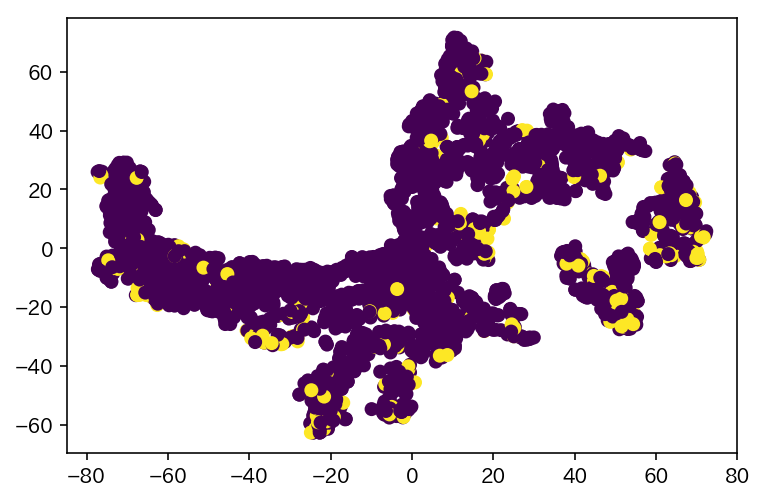

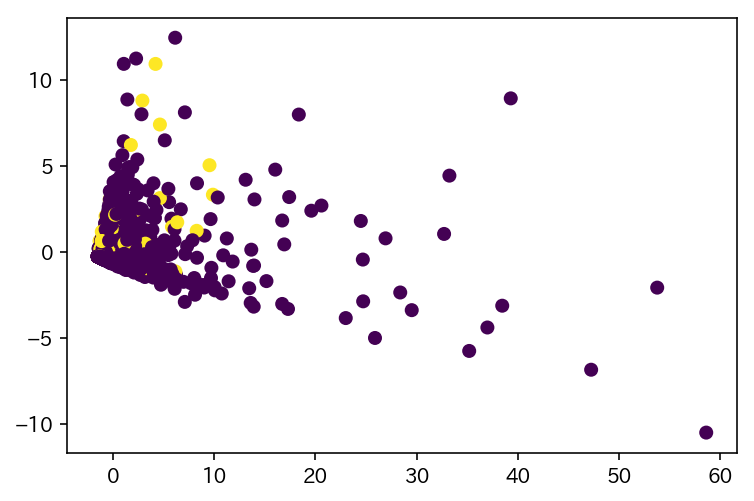

In [90]:
tmp = pd.concat([data["author"], adjective0_df], axis=1).dropna()
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(zscore, axis=0)
tmp = tmp.drop("BOS/EOS", axis=1)

reduced = TSNE(n_components=2, random_state=0).fit_transform(tmp.drop("author", axis=1))
plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])
plt.show()

reduced = PCA(n_components=2).fit_transform(tmp.drop("author", axis=1))
plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])
plt.show()

In [88]:
kmeans.fit(tmp.drop("author", axis=1))
kmeans_df = pd.DataFrame(data=[tmp["author"], kmeans.labels_]).T
hoge = kmeans_df.groupby("Unnamed 0").sum()/kmeans_df.groupby("Unnamed 0").count()
piyo = (kmeans_df.groupby("Unnamed 0").count() - kmeans_df.groupby("Unnamed 0").sum())/kmeans_df.groupby("Unnamed 0").count()
pd.concat([kmeans_df.groupby("Unnamed 0").count(), hoge, piyo], axis=1)

,author,author,author
Unnamed 0,,,
0.0,213,0.075117,0.924883
1.0,9,0.000000,1.000000
2.0,2271,0.081462,0.918538
3.0,15,0.266667,0.733333
4.0,3,0.000000,1.000000
5.0,24,0.000000,1.000000
6.0,4,0.000000,1.000000
7.0,1,0.000000,1.000000
8.0,684,0.057018,0.942982


In [3]:
def visualize(df):
    tmp = pd.concat([data["author"], df], axis=1).dropna()
    tmp = tmp.dropna(axis=1)
    tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(zscore, axis=0)
    tmp = tmp.dropna(axis=1)

    reduced = TSNE(n_components=2, random_state=0).fit_transform(tmp.drop("author", axis=1))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])
    plt.show()

    reduced = PCA(n_components=2).fit_transform(tmp.drop("author", axis=1))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=tmp["author"])
    plt.show()

    kmeans.fit(tmp.drop("author", axis=1))
    kmeans_df = pd.DataFrame(data=[tmp["author"], kmeans.labels_]).T
    hoge = kmeans_df.groupby("Unnamed 0").sum()/kmeans_df.groupby("Unnamed 0").count()
    piyo = (kmeans_df.groupby("Unnamed 0").count() - kmeans_df.groupby("Unnamed 0").sum())/kmeans_df.groupby("Unnamed 0").count()
    display(pd.concat([kmeans_df.groupby("Unnamed 0").count(), hoge, piyo], axis=1))

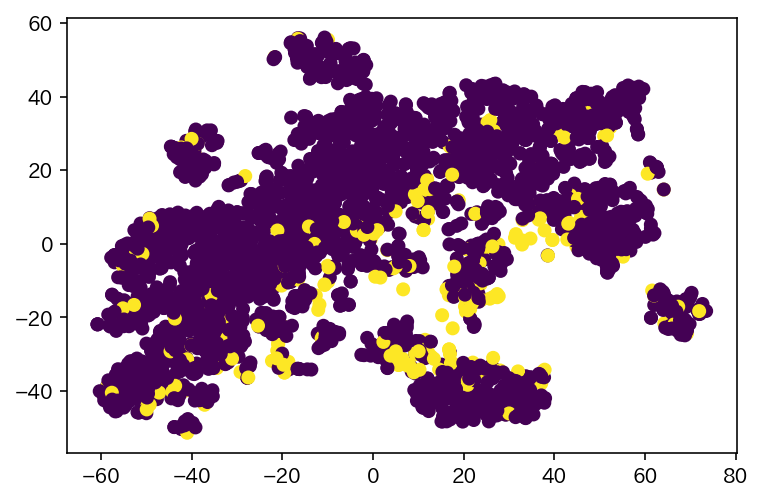

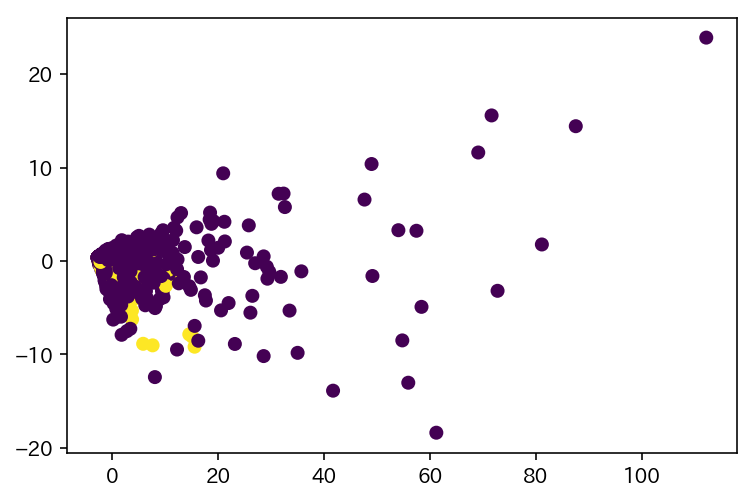

In [110]:
visualize(adjective01_df)

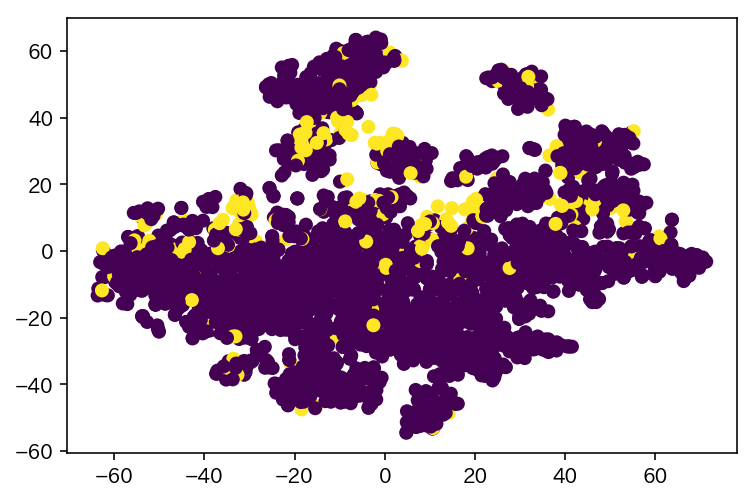

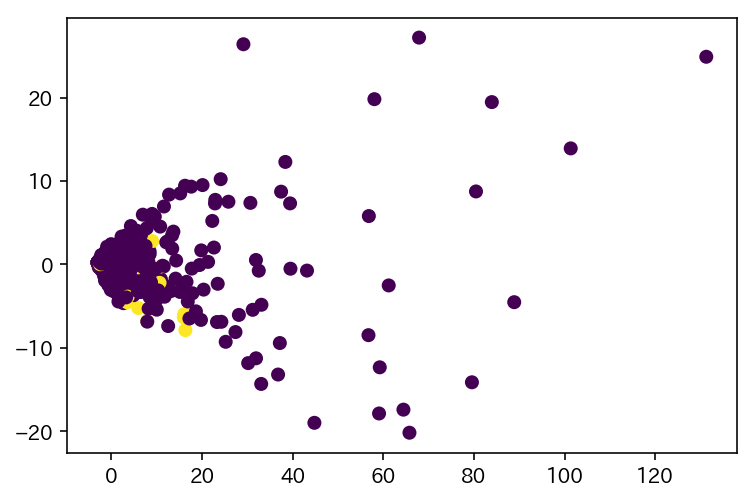

In [108]:
visualize(adjective012_df)

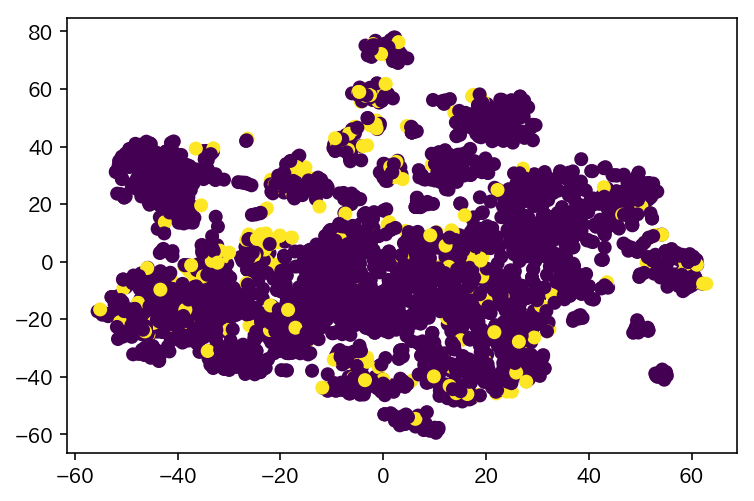

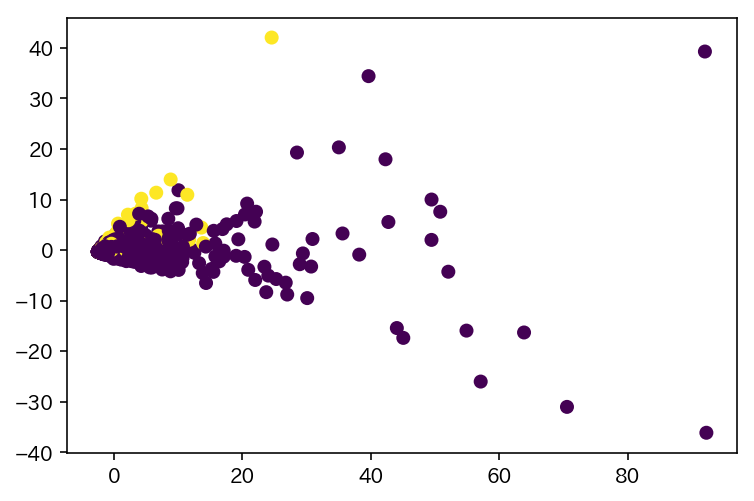

In [111]:
visualize(katsuyo0_df)

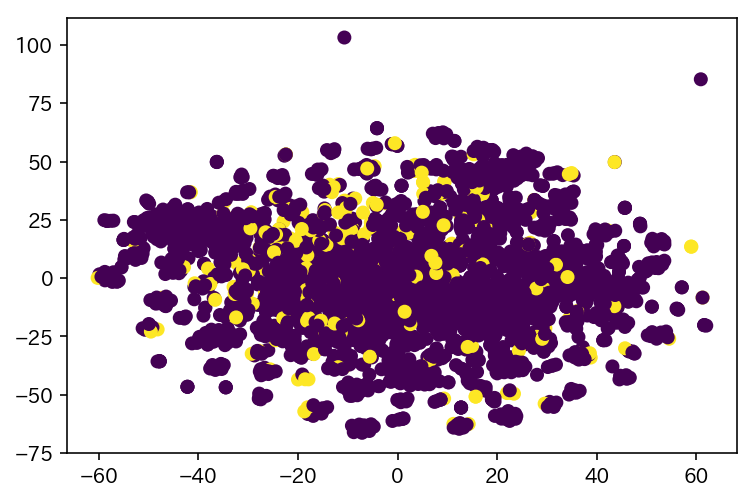

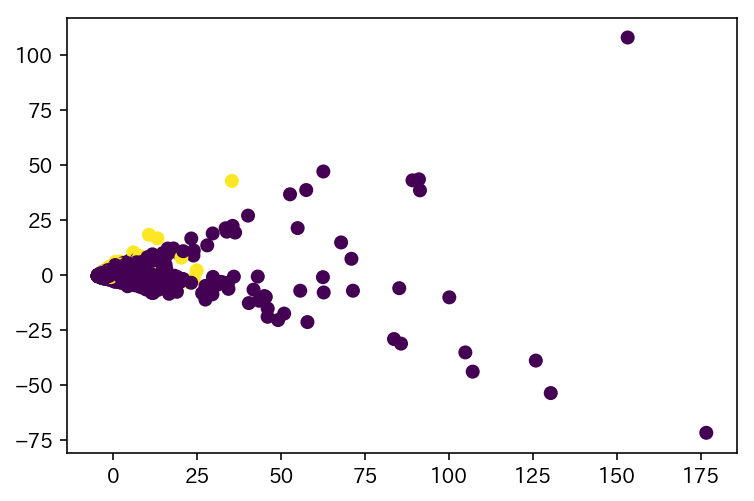

In [112]:
visualize(katsuyo01_df)

In [113]:
del adjective0_df, adjective0_list
del adjective01_df, adjective01_list
del adjective012_df, adjective012_list
del katsuyo0_df, katsuyo0_list
del katsuyo01_df, katsuyo01_list
gc.collect()

126

## ネガポジ

In [114]:
negaposi_dict_df = pd.read_csv("../input/pn_ja.dic.csv", sep=":", encoding="shift-jis", header=None, index_col=0)

In [115]:
negaposi_dict_df = negaposi_dict_df.rename(columns={1: "pronunciation", 2: "adjective", 3: "score"})

In [116]:
negaposi_dict = negaposi_dict_df["score"].to_dict()

In [144]:
def negaposi(word_list):
    columns = ["negaposi_0", "negaposi_1", "negaposi_2", "negaposi_3", "negaposi_mean", "negaposi_std"]
    negaposi_df = pd.DataFrame(index=range(len(word_list)), columns=columns)
    for i, word in tqdm(enumerate(word_list)):
        score = pd.Series(word).map(negaposi_dict).replace({np.nan: 0.0})
        for j in range(4):
            score_quarter = score[int(len(score)/4*j): int(len(score)/4*(j+1))]
            negaposi_df.loc[i, f"negaposi_{j}".format(j)] = score_quarter.sum()/len(score_quarter)
    negaposi_df["negaposi_mean"] = negaposi_df.drop(columns=["negaposi_mean", "negaposi_std"]).mean(axis=1)
    negaposi_df["negaposi_std"] = negaposi_df.drop(columns=["negaposi_mean", "negaposi_std"]).std(axis=1)
    for j in range(4):
        negaposi_df[f"negaposi_{j}".format(j)] = negaposi_df[f"negaposi_{j}".format(j)]-negaposi_df["negaposi_mean"]
    negaposi_df = negaposi_df.astype(float)
    
    return negaposi_df

In [140]:
# def negaposi(word_list):
#     negaposi_df = pd.DataFrame()
#     for i, word in tqdm(enumerate(word_list)):
#         score = pd.Series(word).map(negaposi_dict).replace({np.nan: 0.0})
#         num = int(len(score)/4)
#         score_quarter = pd.DataFrame([score[num*j: num*(j+1)].sum()/num for j in range(4)]).T
#         negaposi_df = pd.concat([negaposi_df, score_quarter])
#     negaposi_df = negaposi_df.rename(columns={0: "negaposi_0", 1: "negaposi_1", 2: "negaposi_2", 3: "negaposi_3"})
#     negaposi_df = pd.concat([negaposi_df, negaposi_df.mean(axis=1)], axis=1)
#     negaposi_df = negaposi_df.rename(columns={0: "negaposi_mean"})
#     negaposi_df = pd.concat([negaposi_df, negaposi_df.std(axis=1)], axis=1)
#     negaposi_df = negaposi_df.rename(columns={0: "negaposi_std"})
#     for j in range(4):
#         negaposi_df[f"negaposi_{j}".format(j)] = negaposi_df[f"negaposi_{j}".format(j)]-negaposi_df["negaposi_mean"]
#     negaposi_df = negaposi_df.astype(float)
    
#     return negaposi_df

In [146]:
negaposi_df = negaposi(word_list)


0it [00:00, ?it/s]
1it [00:00,  1.64it/s]
2it [00:01,  1.68it/s]
3it [00:01,  1.70it/s]
4it [00:02,  1.71it/s]
5it [00:02,  1.70it/s]
6it [00:03,  1.70it/s]
7it [00:04,  1.73it/s]
8it [00:04,  1.64it/s]
9it [00:05,  1.68it/s]
10it [00:05,  1.71it/s]
11it [00:06,  1.70it/s]
12it [00:07,  1.73it/s]
13it [00:07,  1.73it/s]
14it [00:08,  1.75it/s]
15it [00:08,  1.75it/s]
16it [00:09,  1.76it/s]
17it [00:09,  1.74it/s]
18it [00:10,  1.74it/s]
19it [00:10,  1.76it/s]
20it [00:11,  1.76it/s]
21it [00:12,  1.78it/s]
22it [00:12,  1.78it/s]
23it [00:13,  1.79it/s]
24it [00:13,  1.75it/s]
25it [00:14,  1.76it/s]
26it [00:14,  1.78it/s]
27it [00:15,  1.76it/s]
28it [00:16,  1.78it/s]
29it [00:16,  1.81it/s]
30it [00:17,  1.79it/s]
31it [00:17,  1.74it/s]
32it [00:18,  1.69it/s]
33it [00:18,  1.72it/s]
34it [00:19,  1.76it/s]
35it [00:20,  1.73it/s]
36it [00:20,  1.67it/s]
37it [00:21,  1.51it/s]
38it [00:22,  1.48it/s]
39it [00:22,  1.55it/s]
40it [00:23,  1.62it/s]
41it [00:23,  1.64it/s]
42it 

588it [05:20,  1.85it/s]
589it [05:20,  1.86it/s]
590it [05:21,  1.85it/s]
591it [05:21,  1.87it/s]
592it [05:22,  1.86it/s]
593it [05:22,  1.86it/s]
594it [05:23,  1.86it/s]
595it [05:23,  1.86it/s]
596it [05:24,  1.84it/s]
597it [05:24,  1.84it/s]
598it [05:25,  1.82it/s]
599it [05:25,  1.84it/s]
600it [05:26,  1.83it/s]
601it [05:27,  1.84it/s]
602it [05:27,  1.80it/s]
603it [05:28,  1.83it/s]
604it [05:28,  1.83it/s]
605it [05:29,  1.83it/s]
606it [05:29,  1.84it/s]
607it [05:30,  1.85it/s]
608it [05:30,  1.85it/s]
609it [05:31,  1.84it/s]
610it [05:31,  1.84it/s]
611it [05:32,  1.84it/s]
612it [05:33,  1.85it/s]
613it [05:33,  1.85it/s]
614it [05:34,  1.85it/s]
615it [05:34,  1.86it/s]
616it [05:35,  1.85it/s]
617it [05:35,  1.86it/s]
618it [05:36,  1.87it/s]
619it [05:36,  1.87it/s]
620it [05:37,  1.86it/s]
621it [05:37,  1.87it/s]
622it [05:38,  1.86it/s]
623it [05:38,  1.87it/s]
624it [05:39,  1.85it/s]
625it [05:40,  1.85it/s]
626it [05:40,  1.86it/s]
627it [05:41,  1.87it/s]


1166it [10:32,  1.85it/s]
1167it [10:33,  1.82it/s]
1168it [10:33,  1.82it/s]
1169it [10:34,  1.83it/s]
1170it [10:34,  1.84it/s]
1171it [10:35,  1.84it/s]
1172it [10:36,  1.81it/s]
1173it [10:36,  1.82it/s]
1174it [10:37,  1.83it/s]
1175it [10:37,  1.84it/s]
1176it [10:38,  1.85it/s]
1177it [10:38,  1.86it/s]
1178it [10:39,  1.86it/s]
1179it [10:39,  1.86it/s]
1180it [10:40,  1.85it/s]
1181it [10:40,  1.86it/s]
1182it [10:41,  1.87it/s]
1183it [10:41,  1.87it/s]
1184it [10:42,  1.88it/s]
1185it [10:43,  1.86it/s]
1186it [10:43,  1.86it/s]
1187it [10:44,  1.86it/s]
1188it [10:44,  1.86it/s]
1189it [10:45,  1.86it/s]
1190it [10:45,  1.87it/s]
1191it [10:46,  1.87it/s]
1192it [10:46,  1.86it/s]
1193it [10:47,  1.84it/s]
1194it [10:47,  1.85it/s]
1195it [10:48,  1.84it/s]
1196it [10:48,  1.85it/s]
1197it [10:49,  1.84it/s]
1198it [10:50,  1.86it/s]
1199it [10:50,  1.85it/s]
1200it [10:51,  1.86it/s]
1201it [10:51,  1.87it/s]
1202it [10:52,  1.87it/s]
1203it [10:52,  1.85it/s]
1204it [10:5

1730it [15:38,  1.83it/s]
1731it [15:39,  1.83it/s]
1732it [15:39,  1.84it/s]
1733it [15:40,  1.84it/s]
1734it [15:40,  1.82it/s]
1735it [15:41,  1.84it/s]
1736it [15:42,  1.84it/s]
1737it [15:42,  1.81it/s]
1738it [15:43,  1.83it/s]
1739it [15:43,  1.83it/s]
1740it [15:44,  1.84it/s]
1741it [15:44,  1.84it/s]
1742it [15:45,  1.86it/s]
1743it [15:45,  1.86it/s]
1744it [15:46,  1.87it/s]
1745it [15:46,  1.85it/s]
1746it [15:47,  1.84it/s]
1747it [15:47,  1.84it/s]
1748it [15:48,  1.83it/s]
1749it [15:49,  1.84it/s]
1750it [15:49,  1.83it/s]
1751it [15:50,  1.84it/s]
1752it [15:50,  1.84it/s]
1753it [15:51,  1.86it/s]
1754it [15:51,  1.85it/s]
1755it [15:52,  1.85it/s]
1756it [15:52,  1.86it/s]
1757it [15:53,  1.77it/s]
1758it [15:54,  1.80it/s]
1759it [15:54,  1.81it/s]
1760it [15:55,  1.83it/s]
1761it [15:55,  1.84it/s]
1762it [15:56,  1.84it/s]
1763it [15:56,  1.85it/s]
1764it [15:57,  1.85it/s]
1765it [15:57,  1.85it/s]
1766it [15:58,  1.86it/s]
1767it [15:58,  1.86it/s]
1768it [15:5

2294it [20:47,  1.41it/s]
2295it [20:48,  1.44it/s]
2296it [20:49,  1.47it/s]
2297it [20:50,  1.32it/s]
2298it [20:50,  1.35it/s]
2299it [20:51,  1.39it/s]
2300it [20:52,  1.43it/s]
2301it [20:52,  1.47it/s]
2302it [20:53,  1.32it/s]
2303it [20:54,  1.41it/s]
2304it [20:54,  1.46it/s]
2305it [20:55,  1.52it/s]
2306it [20:56,  1.59it/s]
2307it [20:56,  1.66it/s]
2308it [20:57,  1.72it/s]
2309it [20:57,  1.72it/s]
2310it [20:58,  1.76it/s]
2311it [20:58,  1.78it/s]
2312it [20:59,  1.81it/s]
2313it [20:59,  1.82it/s]
2314it [21:00,  1.84it/s]
2315it [21:00,  1.85it/s]
2316it [21:01,  1.84it/s]
2317it [21:02,  1.86it/s]
2318it [21:02,  1.85it/s]
2319it [21:03,  1.86it/s]
2320it [21:03,  1.85it/s]
2321it [21:04,  1.87it/s]
2322it [21:04,  1.85it/s]
2323it [21:05,  1.85it/s]
2324it [21:05,  1.87it/s]
2325it [21:06,  1.87it/s]
2326it [21:06,  1.83it/s]
2327it [21:07,  1.84it/s]
2328it [21:07,  1.85it/s]
2329it [21:08,  1.86it/s]
2330it [21:09,  1.87it/s]
2331it [21:09,  1.87it/s]
2332it [21:1

2858it [25:50,  1.87it/s]
2859it [25:50,  1.88it/s]
2860it [25:51,  1.88it/s]
2861it [25:52,  1.88it/s]
2862it [25:52,  1.85it/s]
2863it [25:53,  1.87it/s]
2864it [25:53,  1.78it/s]
2865it [25:54,  1.81it/s]
2866it [25:54,  1.83it/s]
2867it [25:55,  1.84it/s]
2868it [25:55,  1.84it/s]
2869it [25:56,  1.84it/s]
2870it [25:56,  1.85it/s]
2871it [25:57,  1.85it/s]
2872it [25:58,  1.85it/s]
2873it [25:58,  1.86it/s]
2874it [25:59,  1.87it/s]
2875it [25:59,  1.86it/s]
2876it [26:00,  1.88it/s]
2877it [26:00,  1.88it/s]
2878it [26:01,  1.89it/s]
2879it [26:01,  1.88it/s]
2880it [26:02,  1.87it/s]
2881it [26:02,  1.88it/s]
2882it [26:03,  1.87it/s]
2883it [26:03,  1.88it/s]
2884it [26:04,  1.88it/s]
2885it [26:04,  1.89it/s]
2886it [26:05,  1.87it/s]
2887it [26:06,  1.88it/s]
2888it [26:06,  1.89it/s]
2889it [26:07,  1.87it/s]
2890it [26:07,  1.88it/s]
2891it [26:08,  1.89it/s]
2892it [26:08,  1.88it/s]
2893it [26:09,  1.89it/s]
2894it [26:09,  1.88it/s]
2895it [26:10,  1.89it/s]
2896it [26:1

3422it [30:52,  1.88it/s]
3423it [30:52,  1.89it/s]
3424it [30:53,  1.90it/s]
3425it [30:53,  1.78it/s]
3426it [30:54,  1.81it/s]
3427it [30:54,  1.83it/s]
3428it [30:55,  1.85it/s]
3429it [30:55,  1.86it/s]
3430it [30:56,  1.85it/s]
3431it [30:56,  1.86it/s]
3432it [30:57,  1.87it/s]
3433it [30:58,  1.88it/s]
3434it [30:58,  1.89it/s]
3435it [30:59,  1.89it/s]
3436it [30:59,  1.88it/s]
3437it [31:00,  1.88it/s]
3438it [31:00,  1.88it/s]
3439it [31:01,  1.89it/s]
3440it [31:01,  1.88it/s]
3441it [31:02,  1.89it/s]
3442it [31:02,  1.87it/s]
3443it [31:03,  1.86it/s]
3444it [31:03,  1.87it/s]
3445it [31:04,  1.87it/s]
3446it [31:04,  1.88it/s]
3447it [31:05,  1.87it/s]
3448it [31:06,  1.87it/s]
3449it [31:06,  1.87it/s]
3450it [31:07,  1.88it/s]
3451it [31:07,  1.89it/s]
3452it [31:08,  1.89it/s]
3453it [31:08,  1.89it/s]
3454it [31:09,  1.88it/s]
3455it [31:09,  1.88it/s]
3456it [31:10,  1.87it/s]
3457it [31:10,  1.88it/s]
3458it [31:11,  1.88it/s]
3459it [31:11,  1.89it/s]
3460it [31:1

3986it [35:54,  1.83it/s]
3987it [35:55,  1.84it/s]
3988it [35:55,  1.84it/s]
3989it [35:56,  1.84it/s]
3990it [35:57,  1.84it/s]
3991it [35:57,  1.85it/s]
3992it [35:58,  1.85it/s]
3993it [35:58,  1.86it/s]
3994it [35:59,  1.86it/s]
3995it [35:59,  1.87it/s]
3996it [36:00,  1.87it/s]
3997it [36:00,  1.88it/s]
3998it [36:01,  1.88it/s]
3999it [36:01,  1.87it/s]
4000it [36:02,  1.86it/s]
4001it [36:02,  1.87it/s]
4002it [36:03,  1.86it/s]
4003it [36:03,  1.87it/s]
4004it [36:04,  1.88it/s]
4005it [36:05,  1.73it/s]
4006it [36:05,  1.63it/s]
4007it [36:06,  1.65it/s]
4008it [36:07,  1.70it/s]
4009it [36:07,  1.74it/s]
4010it [36:08,  1.78it/s]
4011it [36:08,  1.76it/s]
4012it [36:09,  1.71it/s]
4013it [36:09,  1.68it/s]
4014it [36:10,  1.73it/s]
4015it [36:10,  1.78it/s]
4016it [36:11,  1.81it/s]
4017it [36:12,  1.84it/s]
4018it [36:12,  1.85it/s]
4019it [36:13,  1.85it/s]
4020it [36:13,  1.85it/s]
4021it [36:14,  1.85it/s]
4022it [36:14,  1.80it/s]
4023it [36:15,  1.82it/s]
4024it [36:1

4550it [40:57,  1.88it/s]
4551it [40:57,  1.88it/s]
4552it [40:58,  1.87it/s]
4553it [40:58,  1.88it/s]
4554it [40:59,  1.88it/s]
4555it [40:59,  1.88it/s]
4556it [41:00,  1.88it/s]
4557it [41:00,  1.89it/s]
4558it [41:01,  1.88it/s]
4559it [41:01,  1.88it/s]
4560it [41:02,  1.88it/s]
4561it [41:03,  1.88it/s]
4562it [41:03,  1.87it/s]
4563it [41:04,  1.84it/s]
4564it [41:04,  1.85it/s]
4565it [41:05,  1.86it/s]
4566it [41:05,  1.86it/s]
4567it [41:06,  1.86it/s]
4568it [41:06,  1.87it/s]
4569it [41:07,  1.88it/s]
4570it [41:07,  1.87it/s]
4571it [41:08,  1.88it/s]
4572it [41:08,  1.88it/s]
4573it [41:09,  1.87it/s]
4574it [41:09,  1.87it/s]
4575it [41:10,  1.88it/s]
4576it [41:11,  1.88it/s]
4577it [41:11,  1.88it/s]
4578it [41:12,  1.89it/s]
4579it [41:12,  1.88it/s]
4580it [41:13,  1.89it/s]
4581it [41:13,  1.88it/s]
4582it [41:14,  1.87it/s]
4583it [41:14,  1.87it/s]
4584it [41:15,  1.88it/s]
4585it [41:15,  1.87it/s]
4586it [41:16,  1.86it/s]
4587it [41:16,  1.88it/s]
4588it [41:1

,negaposi_0,negaposi_1,negaposi_2,negaposi_3,negaposi_mean,negaposi_std
0,-0.008959,-0.026133,0.001534,0.033558,-0.149220,0.025111
1,-0.001320,-0.051084,0.027209,0.025195,-0.133101,0.036453
2,-0.006494,0.000760,-0.021711,0.027444,-0.190386,0.020553
3,-0.005741,0.004553,0.010287,-0.009100,-0.174365,0.008987
4,-0.024023,0.023435,-0.005564,0.006152,-0.176879,0.019959
5,0.002984,0.001738,-0.004676,-0.000046,-0.155715,0.003356
6,-0.012257,-0.003049,0.013151,0.002154,-0.144991,0.010601
7,-0.006974,-0.017298,0.041292,-0.017020,-0.110433,0.027944
8,0.007921,-0.009098,0.009120,-0.007944,-0.130927,0.009862
9,-0.019600,0.001547,0.000193,0.017860,-0.135904,0.015336


In [147]:
negaposi_df.to_csv("../input/feature_negaposi.csv")

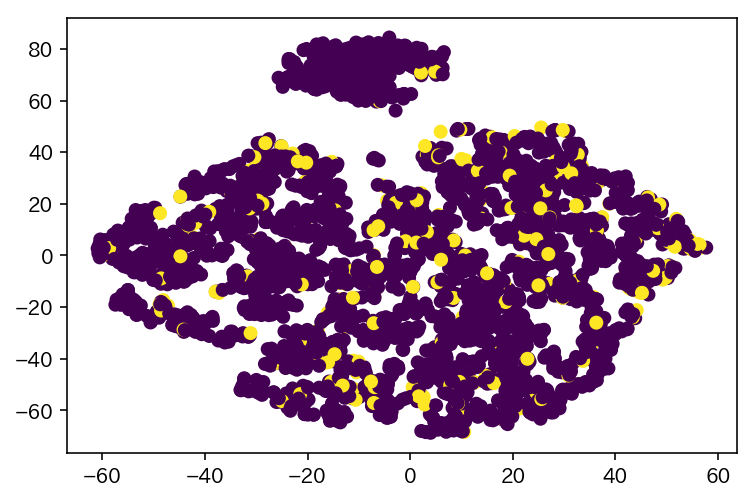

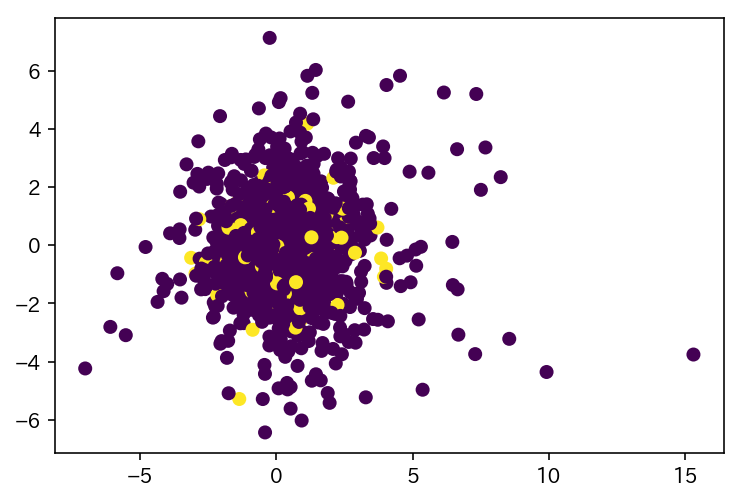

In [148]:
visualize(negaposi_df)

In [149]:
del negaposi_df
gc.collect()

85

## ...

In [ ]:
# feature = pd.concat([
# #     data["author"],
#     hyoki_df,
#     word_df,
#     adjective0_df,
#     adjective01_df,
#     adjective012_df,
#     katsuyo0_df,
#     katsuyo01_df,
#     negaposi_df],
#     axis=1)

In [ ]:
# feature.to_csv("../input/feature.csv")

In [10]:
data["author"]

0       0.0
1       0.0
2       0.0
3       1.0
4       0.0
5       0.0
6       0.0
7       1.0
8       0.0
9       0.0
10      0.0
11      0.0
12      0.0
13      0.0
14      0.0
15      0.0
16      0.0
17      0.0
18      0.0
19      0.0
20      0.0
21      0.0
22      0.0
23      0.0
24      0.0
25      0.0
26      0.0
27      0.0
28      0.0
29      0.0
       ... 
4702    NaN
4703    NaN
4704    NaN
4705    NaN
4706    NaN
4707    NaN
4708    NaN
4709    NaN
4710    NaN
4711    NaN
4712    NaN
4713    NaN
4714    NaN
4715    NaN
4716    NaN
4717    NaN
4718    NaN
4719    NaN
4720    NaN
4721    NaN
4722    NaN
4723    NaN
4724    NaN
4725    NaN
4726    NaN
4727    NaN
4728    NaN
4729    NaN
4730    NaN
4731    NaN
Name: author, Length: 4732, dtype: float64

In [34]:
data["author"].to_csv("../input/target.csv")

In [39]:
target = pd.read_csv("../input/target.csv", index_col=0, names=["target"])
target

,target
0,0.0
1,0.0
2,0.0
3,1.0
4,0.0
5,0.0
6,0.0
7,1.0
8,0.0
9,0.0
